Now we will train the High Level Feature classifier.

To run this notebook we used the following configuration:
* *Software stack*: LCG 94 (it has spark 2.3.1)
* *Platform*: centos7-gcc7
* *Spark cluster*: Hadalytic

In [1]:
# Check if Spark Session has been created correctly
spark

In [2]:
# Add the BDL zip file
#sc.addPyFile("/eos/project/s/swan/public/BigDL/bigdl-0.7.0-python-api.zip")

## Load train and test dataset

In [3]:
PATH = "file:///data/cern/"

trainDF = spark.read.format('parquet')\
        .load(PATH + 'trainUndersampled.parquet')\
        .select(['HLF_input', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load(PATH + 'testUndersampled.parquet')\
        .select(['HLF_input', 'encoded_label'])

In [4]:
trainDF.printSchema()

root
 |-- HLF_input: vector (nullable = true)
 |-- encoded_label: vector (nullable = true)



## Create the model

In [5]:
# Init analytics zoo
from zoo.common.nncontext import *
sc = init_nncontext("hlf classifier")

In [6]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [7]:
# Create keras like zoo model.
# Only need to change package name from keras to zoo.pipeline.api.keras

from zoo.pipeline.api.keras.optimizers import Adam
from zoo.pipeline.api.keras.models import Sequential
from zoo.pipeline.api.keras.layers.core import Dense, Activation

model = Sequential()
model.add(Dense(50, input_shape=(14,), activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense


## Create train and valiation DataFrame

No need to change to RDD of Sample, just use dataframe

In [8]:
# Let's have a look at one element of trainDF
trainDF.show(1, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|HLF_input                                                                                                                                                                                                |encoded_label|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|[0.010696109580467801,0.03581727369726868,0.6577833047712135,0.0020216866244454996,0.07692307692307693,0.0,0.00600872373025112,0.6999402220930278,0.29771337282431887,0.7611435535579052,0.0,0.0,0.0,0.0]|(3,[0],[1.0])|
+-------------------------------------------------------------------------------------------------------------------------------

We can see the 14 high level features (`shape=[14]`) and the encoded label (`shape=[3]`).

## Estimator setup and training

In [9]:
# Set of hyperparameters
numEpochs = 50

# The batch used by BDL must be a multiple of numExecutors * executorCores
# Because data will be equally distibuted inside each executor

workerBatch = 50
# numExecutors = int(sc._conf.get('spark.executor.instances'))
numExecutors = 1
# executorCores = int(sc._conf.get('spark.executor.cores'))
executorCores = 4

BDLbatch = workerBatch * numExecutors * executorCores

In [10]:
# Create SparkML compatible estimator for deep learning training

from bigdl.optim.optimizer import EveryEpoch, Loss, TrainSummary, ValidationSummary
from zoo.pipeline.nnframes import *
from zoo.pipeline.api.keras.objectives import CategoricalCrossEntropy

estimator = NNEstimator(model, CategoricalCrossEntropy())\
        .setOptimMethod(Adam()) \
        .setBatchSize(BDLbatch) \
        .setMaxEpoch(numEpochs) \
        .setFeaturesCol("HLF_input") \
        .setLabelCol("encoded_label") \
        .setValidation(trigger=EveryEpoch() , val_df=testDF,
                       val_method=[Loss(CategoricalCrossEntropy())], batch_size=BDLbatch)

creating: createZooKerasCategoricalCrossEntropy
creating: createSeqToTensor
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNEstimator
creating: createZooKerasAdam
creating: createDefault
creating: createEveryEpoch
creating: createZooKerasCategoricalCrossEntropy
creating: createLoss


Let's define a directory to store logs (i.e. train and validation losses) and save models

In [11]:
# name of our application
appName = "HLFclassifier"

# Change it! 
logDir = "/data/cern/ZOOlogs"

# Check if there is already an application with the same name 
# and remove it, otherwise logs will be appended to that app
import os
try:
    os.system('rm -rf '+logDir+'/'+appName)
except:
    pass

print("Saving logs to {}".format(logDir+'/'+appName))

Saving logs to /data/cern/ZOOlogs/HLFclassifier


In [12]:
trainSummary = TrainSummary(log_dir=logDir,app_name=appName)
estimator.setTrainSummary(trainSummary)

valSummary = ValidationSummary(log_dir=logDir,app_name=appName)
estimator.setValidationSummary(valSummary)

creating: createTrainSummary
creating: createValidationSummary


NNEstimator_4b5e9b48a4ee23c6c97b

We are now ready to launch the training.

Warnign: During the trainign it would be better to shutdown the Toggle Spark Monitorin Display because each iteration is seen as a spark job, therefore the toggle will try to display everything causing problem to the browser. 

In [13]:
%%time 
trained_model = estimator.fit(trainDF)

creating: createToTuple
creating: createChainedPreprocessing
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 34.8 s


## Plot loss

<IPython.core.display.Javascript object>


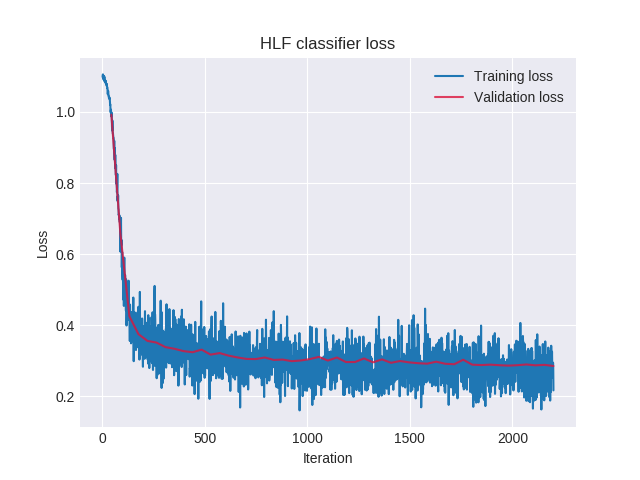

In [17]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib notebook

loss = np.array(trainSummary.read_scalar("Loss"))
val_loss = np.array(valSummary.read_scalar("Loss"))

plt.plot(loss[:,0], loss[:,1], label="Training loss")
plt.plot(val_loss[:,0], val_loss[:,1], label="Validation loss", color='crimson', alpha=0.8)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title("HLF classifier loss")
plt.show()

## Save the model

In [18]:
modelDir = os.path.join(logDir, "models", "hlf")
trained_model.save(modelDir)

NNModel_4219a18693dd4e548568

It is possible to load the model in the following way:
```Python
model = NNModel.load(path=modelDir)
```
The default feature column name is "features", if your feature column is different, set feature column with this way:
```
model = model.setFeaturesCol("HLF_input")
```

## Prediction

In [19]:
# Predict with trained NNModel using pipeline transform API
predDF = trained_model.transform(testDF)

In [20]:
predDF.printSchema()

root
 |-- HLF_input: vector (nullable = true)
 |-- encoded_label: vector (nullable = true)
 |-- prediction: array (nullable = false)
 |    |-- element: float (containsNull = false)



In [21]:
y_pred = np.asarray(predDF.select("prediction").collect())
y_true = np.asarray(testDF.select('encoded_label').rdd\
                    .map(lambda row: np.asarray(row.encoded_label)).collect())

In [22]:
y_pred = np.squeeze(y_pred)
y_pred.shape

(2123, 3)

In [23]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


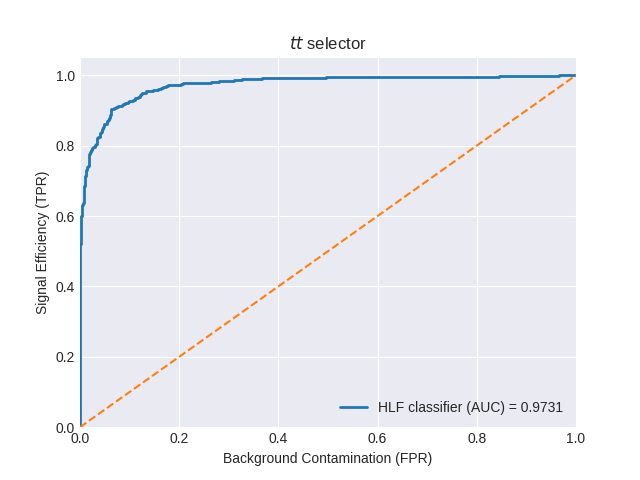

In [24]:
plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()